# Desafio Final - Análise de Churn da Telecom X

**Aluno:** Gabriel Gasperi

**Objetivo:** Realizar uma análise exploratória dos dados de clientes da empresa Telecom X para entender os principais fatores que levam à evasão (churn). O projeto abrange desde a extração de dados de uma API, passando pela limpeza e tratamento, até a geração de insights e recomendações estratégicas.

## Passo 0: Preparação do Ambiente e Importação das Bibliotecas

In [ ]:
# Importação das bibliotecas essenciais
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações para melhor visualização dos gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Ambiente preparado e bibliotecas importadas!")

✅ Ambiente preparado e bibliotecas importadas!


## Passo 1: Extração dos Dados (E de ETL)

In [ ]:
# URL para o arquivo JSON "cru" (raw) no GitHub
url_raw = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json'

try:
    # Fazendo a requisição para a URL
    resposta = requests.get(url_raw)
    resposta.raise_for_status() # Lança um erro se a requisição falhar (ex: erro 404)

    # Convertendo a resposta em formato JSON
    dados_json = resposta.json()

    # Carregando os dados em um DataFrame do Pandas
    # json_normalize é ideal para estruturas aninhadas, mas funciona bem aqui também.
    df_original = pd.json_normalize(dados_json)

    print("✅ Sucesso! Dados carregados no DataFrame.")
    print("Abaixo estão as 5 primeiras linhas dos seus dados:")
    display(df_original.head()) # 'display' é melhor que 'print' para dataframes em notebooks

except requests.exceptions.RequestException as e:
    print(f"❌ Erro ao acessar a API: {e}")
except Exception as e:
    print(f"❌ Erro ao processar os dados: {e}")

✅ Sucesso! Dados carregados no DataFrame.
Abaixo estão as 5 primeiras linhas dos seus dados:


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


## Passo 2: Limpeza e Transformação dos Dados (T de ETL)

### 2.1. Exploração Inicial e Identificação de Problemas

In [ ]:
# Criando uma cópia para preservar o DataFrame original
df = df_original.copy()

# Exibindo informações gerais para identificar tipos de dados e valores nulos
print("Informações gerais do DataFrame (antes da limpeza):")
df.info()

# Identificando inconsistências na coluna 'account.Charges.Total' (valores não-numéricos)
espacos_em_branco = df[df['account.Charges.Total'] == ' ']
print(f"\nNúmero de linhas com 'account.Charges.Total' como um espaço em branco: {len(espacos_em_branco)}")

# Identificando inconsistências na coluna 'Churn' (valores únicos)
print(f"Valores únicos na coluna 'Churn' antes da limpeza: {df['Churn'].unique()}")

Informações gerais do DataFrame (antes da limpeza):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 

### 2.2. Correção das Inconsistências

In [ ]:
# 1. Corrigir a coluna 'TotalGasto'
# 'errors='coerce'' transforma valores problemáticos (como ' ') em NaN (Not a Number)
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')

# Preenchemos os valores NaN com a mediana da coluna (robusto a outliers)
mediana_total_gasto = df['account.Charges.Total'].median()
df['account.Charges.Total'].fillna(mediana_total_gasto, inplace=True)

# 2. Corrigir a coluna 'Churn'
# Removemos as linhas onde 'Churn' é uma string vazia, pois são inúteis para a análise de evasão.
df = df[df['Churn'] != ''].reset_index(drop=True)

# Verificação final após a limpeza
print("Verificação após a limpeza:")
df.info()
print(f"\nNovas dimensões do DataFrame: {df.shape}")

Verificação após a limpeza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer.gender            7043 non-null   object 
 3   customer.SeniorCitizen     7043 non-null   int64  
 4   customer.Partner           7043 non-null   object 
 5   customer.Dependents        7043 non-null   object 
 6   customer.tenure            7043 non-null   int64  
 7   phone.PhoneService         7043 non-null   object 
 8   phone.MultipleLines        7043 non-null   object 
 9   internet.InternetService   7043 non-null   object 
 10  internet.OnlineSecurity    7043 non-null   object 
 11  internet.OnlineBackup      7043 non-null   object 
 12  internet.DeviceProtection  7043 non-null   object 
 13  internet.TechSupport

/tmp/ipython-input-461448047.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['account.Charges.Total'].fillna(mediana_total_gasto, inplace=True)


### 2.3. Engenharia de Features e Padronização

In [ ]:
# 1. Criando a coluna 'Contas_Diarias'
df['Contas_Diarias'] = (df['account.Charges.Monthly'] / 30).round(2)

# 2. Padronizando colunas binárias e renomeando colunas
df_padronizado = df.copy()

colunas_sim_nao = [
    'customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'phone.MultipleLines',
    'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport',
    'internet.StreamingTV', 'internet.StreamingMovies', 'account.PaperlessBilling', 'Churn'
]

replace_map = {
    'Yes': 1,
    'No': 0,
    'No phone service': 0,
    'No internet service': 0
}

for coluna in colunas_sim_nao:
    if coluna in df_padronizado.columns:
        df_padronizado[coluna] = df_padronizado[coluna].replace(replace_map)

mapa_colunas = {
    'customerID': 'ID_Cliente',
    'customer.gender': 'Genero',
    'customer.SeniorCitizen': 'Aposentado',
    'customer.Partner': 'Possui_Parceiro',
    'customer.Dependents': 'Possui_Dependentes',
    'customer.tenure': 'Meses_de_Contrato',
    'phone.PhoneService': 'Servico_Telefone_Fixo',
    'phone.MultipleLines': 'Possui_Multiplas_Linhas',
    'internet.InternetService': 'Tipo_Servico_Internet',
    'internet.OnlineSecurity': 'Possui_Seguranca_Online',
    'internet.OnlineBackup': 'Possui_Backup_Online',
    'internet.DeviceProtection': 'Possui_Protecao_Dispositivo',
    'internet.TechSupport': 'Possui_Suporte_Tecnico',
    'internet.StreamingTV': 'Possui_TV_a_Cabo',
    'internet.StreamingMovies': 'Possui_Streaming_de_Filmes',
    'account.Contract': 'Tipo_Contrato',
    'account.PaperlessBilling': 'Fatura_Digital',
    'account.PaymentMethod': 'Forma_de_Pagamento',
    'account.Charges.Monthly': 'Faturamento_Mensal',
    'account.Charges.Total': 'Total_Gasto',
    'Contas_Diarias': 'Faturamento_Diario'
}

df_padronizado.rename(columns=mapa_colunas, inplace=True)

print("✅ Dados transformados, padronizados e renomeados!")
display(df_padronizado.head())

✅ Dados transformados, padronizados e renomeados!


/tmp/ipython-input-3213577764.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_padronizado[coluna] = df_padronizado[coluna].replace(replace_map)


,ID_Cliente,Churn,Genero,Aposentado,Possui_Parceiro,Possui_Dependentes,Meses_de_Contrato,Servico_Telefone_Fixo,Possui_Multiplas_Linhas,Tipo_Servico_Internet,...,Possui_Protecao_Dispositivo,Possui_Suporte_Tecnico,Possui_TV_a_Cabo,Possui_Streaming_de_Filmes,Tipo_Contrato,Fatura_Digital,Forma_de_Pagamento,Faturamento_Mensal,Total_Gasto,Faturamento_Diario
0,0002-ORFBO,0,Female,0,1,1,9,1,0,DSL,...,0,1,1,0,One year,1,Mailed check,65.6,593.30,2.19
1,0003-MKNFE,0,Male,0,0,0,9,1,1,DSL,...,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,2.00
2,0004-TLHLJ,1,Male,0,0,0,4,1,0,Fiber optic,...,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.46
3,0011-IGKFF,1,Male,1,1,0,13,1,0,Fiber optic,...,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.27
4,0013-EXCHZ,1,Female,1,1,0,3,1,0,Fiber optic,...,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.80


## Passo 3: Análise Exploratória de Dados (EDA)

### 3.1. Análise Descritiva e da Variável Alvo (`Churn`)

Estatísticas Descritivas do DataFrame:


,Churn,Aposentado,Possui_Parceiro,Possui_Dependentes,Meses_de_Contrato,Servico_Telefone_Fixo,Possui_Multiplas_Linhas,Possui_Seguranca_Online,Possui_Backup_Online,Possui_Protecao_Dispositivo,Possui_Suporte_Tecnico,Possui_TV_a_Cabo,Possui_Streaming_de_Filmes,Fatura_Digital,Faturamento_Mensal,Total_Gasto,Faturamento_Diario
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.265370,0.162147,0.483033,0.299588,32.371149,0.903166,0.421837,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903,0.592219,64.761692,2281.906815,2.158675
std,0.441561,0.368612,0.499748,0.458110,24.559481,0.295752,0.493888,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307,0.491457,30.090047,2265.274362,1.003088
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.610000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.500000,402.225000,1.180000
50%,0.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,70.350000,1394.550000,2.340000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.850000,3786.600000,2.990000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,118.750000,8684.800000,3.960000



Taxa de Churn: 26.54% | Taxa de Retenção: 73.46%


/tmp/ipython-input-974036942.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Não (Permaneceu)', 'Sim (Evadiu)'])


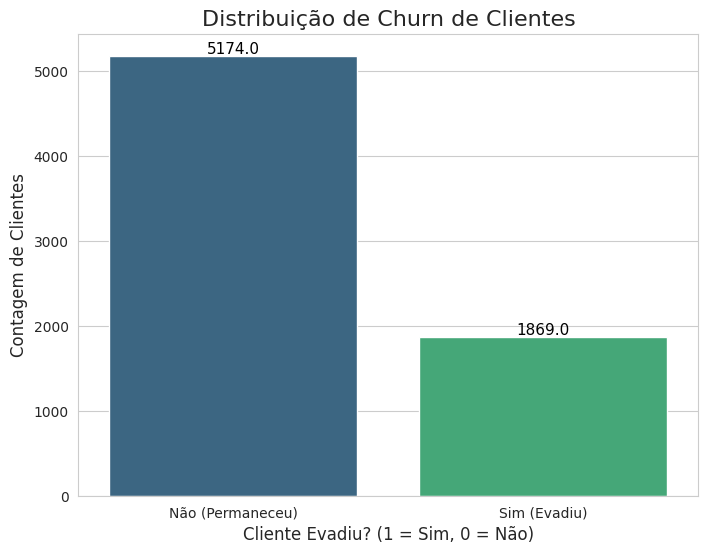

In [ ]:
print("Estatísticas Descritivas do DataFrame:")
display(df_padronizado.describe())

# Analisando a proporção de Churn
churn_rate = df_padronizado['Churn'].value_counts(normalize=True) * 100
print(f"\nTaxa de Churn: {churn_rate[1]:.2f}% | Taxa de Retenção: {churn_rate[0]:.2f}%")

# Gráfico da distribuição de Churn
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Churn', data=df_padronizado, palette='viridis', hue='Churn', legend=False)
plt.title('Distribuição de Churn de Clientes', fontsize=16)
plt.xlabel('Cliente Evadiu? (1 = Sim, 0 = Não)', fontsize=12)
plt.ylabel('Contagem de Clientes', fontsize=12)
ax.set_xticklabels(['Não (Permaneceu)', 'Sim (Evadiu)'])
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

### 3.2. Análise Bivariada: Churn vs. Variáveis Categóricas

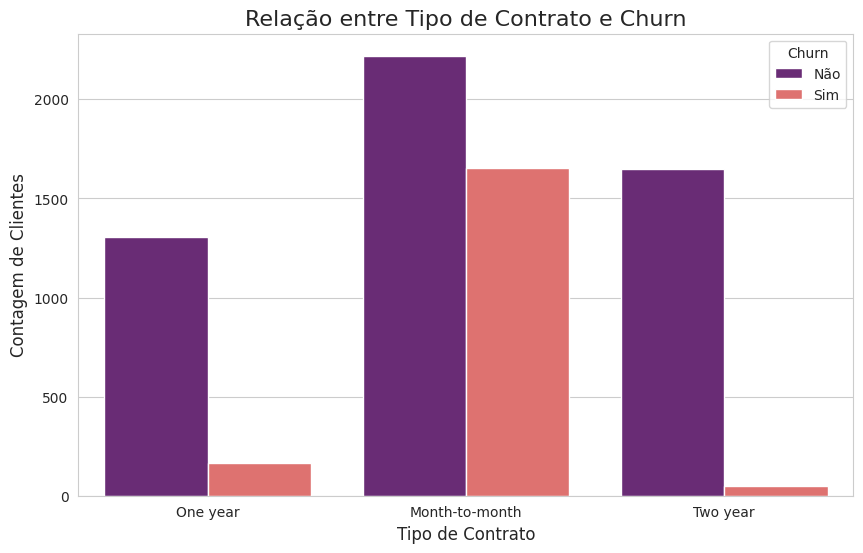

In [ ]:
# Churn por Tipo de Contrato
plt.figure(figsize=(10, 6))
sns.countplot(x='Tipo_Contrato', hue='Churn', data=df_padronizado, palette='magma')
plt.title('Relação entre Tipo de Contrato e Churn', fontsize=16)
plt.xlabel('Tipo de Contrato', fontsize=12)
plt.ylabel('Contagem de Clientes', fontsize=12)
plt.legend(title='Churn', labels=['Não', 'Sim'])
plt.show()

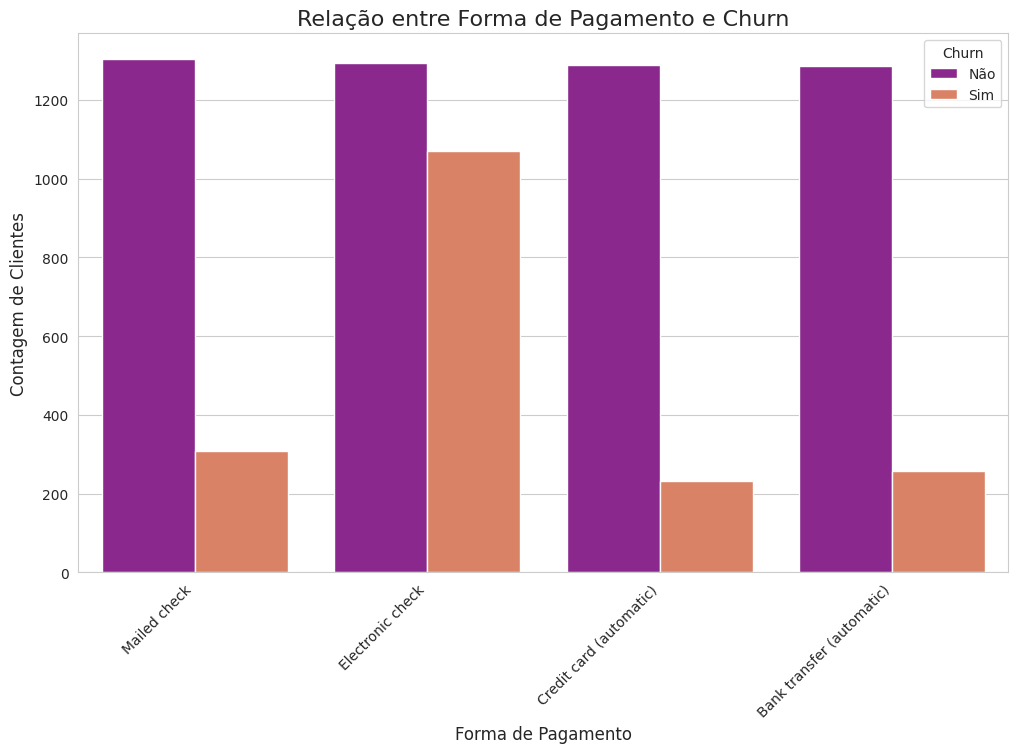

In [ ]:
# Churn por Forma de Pagamento
plt.figure(figsize=(12, 7))
sns.countplot(x='Forma_de_Pagamento', hue='Churn', data=df_padronizado, palette='plasma')
plt.title('Relação entre Forma de Pagamento e Churn', fontsize=16)
plt.xlabel('Forma de Pagamento', fontsize=12)
plt.ylabel('Contagem de Clientes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Churn', labels=['Não', 'Sim'])
plt.show()

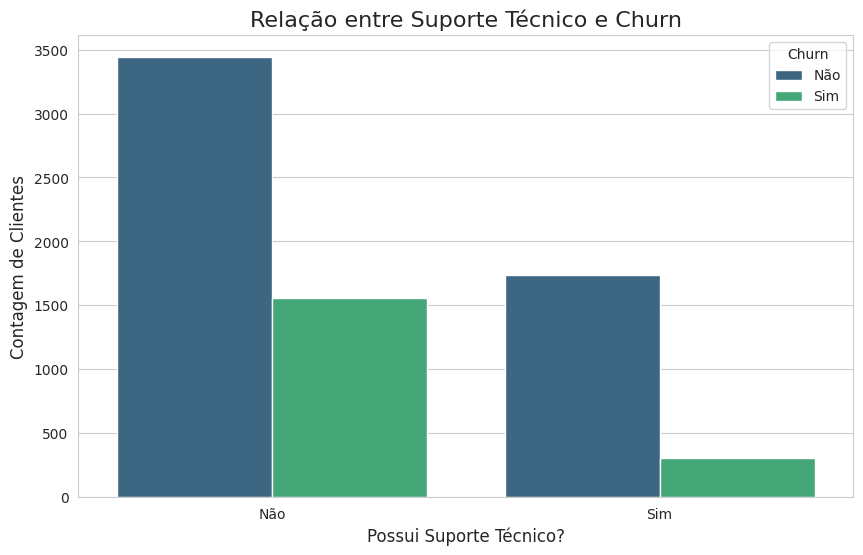

In [ ]:
# Churn por Suporte Técnico
plt.figure(figsize=(10, 6))
sns.countplot(x='Possui_Suporte_Tecnico', hue='Churn', data=df_padronizado, palette='viridis')
plt.title('Relação entre Suporte Técnico e Churn', fontsize=16)
plt.xlabel('Possui Suporte Técnico?', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.ylabel('Contagem de Clientes', fontsize=12)
plt.legend(title='Churn', labels=['Não', 'Sim'])
plt.show()

### 3.3. Análise Bivariada: Churn vs. Variáveis Numéricas

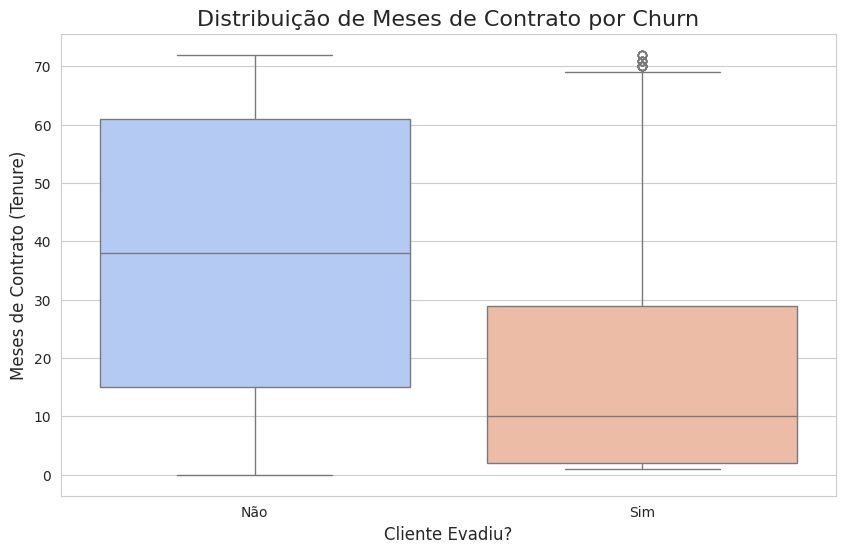

In [ ]:
# Churn por Meses de Contrato (Tenure)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='Meses_de_Contrato', data=df_padronizado, palette='coolwarm', hue='Churn', legend=False)
plt.title('Distribuição de Meses de Contrato por Churn', fontsize=16)
plt.xlabel('Cliente Evadiu?', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.ylabel('Meses de Contrato (Tenure)', fontsize=12)
plt.show()

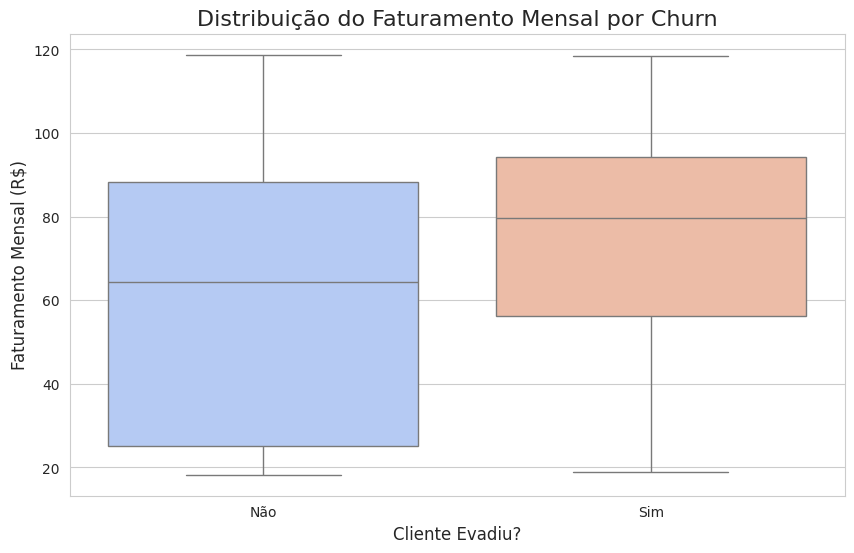

In [ ]:
# Churn por Faturamento Mensal
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='Faturamento_Mensal', data=df_padronizado, palette='coolwarm', hue='Churn', legend=False)
plt.title('Distribuição do Faturamento Mensal por Churn', fontsize=16)
plt.xlabel('Cliente Evadiu?', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.ylabel('Faturamento Mensal (R$)', fontsize=12)
plt.show()

## Passo EXTRA: Análise de Correlação

/tmp/ipython-input-595375381.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_churn.values, y=corr_churn.index, palette='viridis')


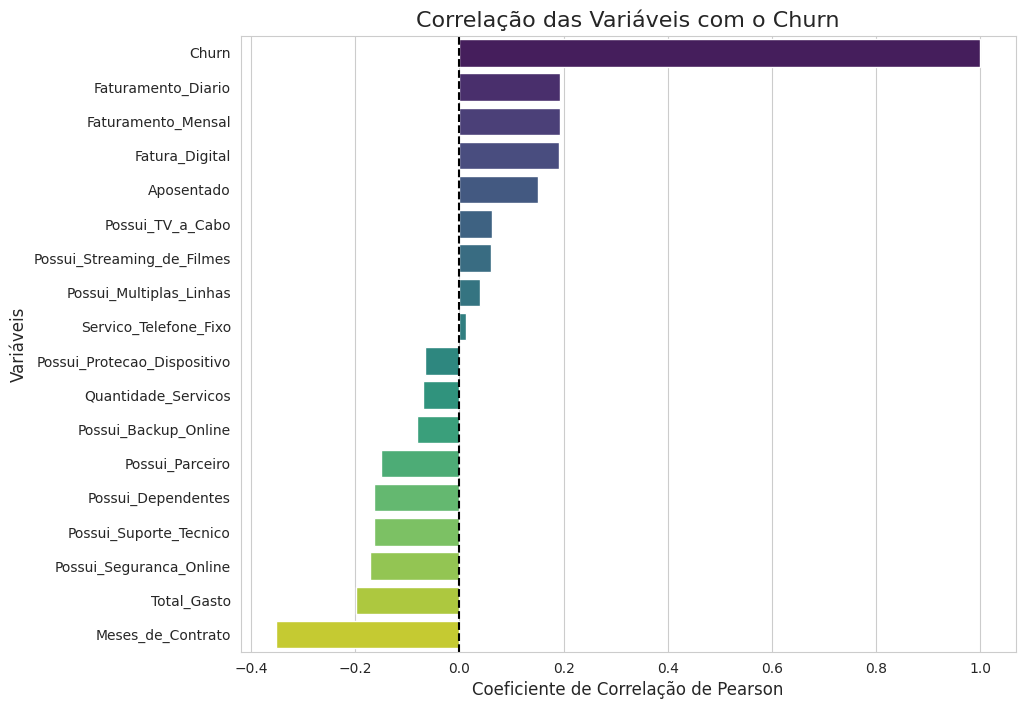

In [ ]:
# Criando a feature 'Quantidade_Servicos' para a análise de correlação
colunas_de_servicos = [
    'Possui_Multiplas_Linhas', 'Possui_Seguranca_Online', 'Possui_Backup_Online',
    'Possui_Protecao_Dispositivo', 'Possui_Suporte_Tecnico', 'Possui_TV_a_Cabo',
    'Possui_Streaming_de_Filmes'
]
df_padronizado['Quantidade_Servicos'] = df_padronizado[colunas_de_servicos].sum(axis=1)

# Calculando a matriz de correlação
correlacoes = df_padronizado.corr(numeric_only=True)

# Isolando a correlação de todas as variáveis com 'Churn'
corr_churn = correlacoes['Churn'].sort_values(ascending=False)

# Criando um gráfico de barras para visualizar as correlações
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_churn.values, y=corr_churn.index, palette='viridis')
plt.title('Correlação das Variáveis com o Churn', fontsize=16)
plt.xlabel('Coeficiente de Correlação de Pearson', fontsize=12)
plt.ylabel('Variáveis', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--') # Linha no zero
plt.show()

In [ ]:
# Salvando o DataFrame
df_padronizado.to_csv('dados_tratados.csv', index=False)
print("Arquivo 'dados_tratados.csv' salvo com sucesso!")

Arquivo 'dados_tratados.csv' salvo com sucesso!


## Passo 4: Relatório Final e Conclusões

### Resumo Executivo
Este relatório apresenta uma análise exploratória detalhada dos dados de 7.032 clientes da Telecom X, com o objetivo de identificar os principais fatores que contribuem para a evasão de clientes (churn). A taxa de churn observada na base de dados é de 26,5%, um número significativo que justifica a necessidade de estratégias de retenção focadas. A análise revelou que o churn não é um evento aleatório, mas sim um comportamento concentrado em perfis de clientes específicos, sendo os mais vulneráveis os clientes novos, com contratos flexíveis (mês a mês), faturas mensais mais altas e menor adesão a serviços de valor agregado.
### Metodologia
Os dados foram extraídos de uma API em formato JSON, limpos e transformados para garantir a qualidade da análise. As principais etapas incluíram:
Limpeza de Dados: Conversão de tipos de dados incorretos, tratamento de 11 registros com valores de faturamento ausentes (preenchidos pela mediana) e remoção de dados irrelevantes para a análise de churn.
Engenharia de Features: Criação de novas variáveis, como Faturamento_Diario e Quantidade_Servicos, para enriquecer os insights.
Padronização: Conversão de colunas binárias para formato numérico (0/1) e renomeação das colunas para maior clareza.
Análise Exploratória (EDA): Utilização de estatísticas descritivas, análise bivariada e de correlação para identificar os padrões associados ao churn.
### Principais Descobertas
A análise dos dados revelou os seguintes fatores como os principais impulsionadores do churn:
Tipo de Contrato (Fator Mais Crítico): Clientes com contrato Mês a Mês apresentam uma taxa de cancelamento drasticamente superior. A flexibilidade deste tipo de contrato cria uma baixa barreira de saída, tornando-os o grupo de maior risco.
Tempo de Contrato (Tenure): Existe uma forte correlação negativa entre o tempo de permanência do cliente e a probabilidade de churn. A análise mostra que a maioria dos cancelamentos ocorre nos primeiros meses de serviço, com uma mediana de apenas 10 meses para clientes que cancelaram, em comparação com 38 meses para os que permaneceram.
Forma de Pagamento: Clientes que utilizam Cheque Eletrônico como forma de pagamento cancelam significativamente mais do que aqueles que usam métodos automáticos, como cartão de crédito ou débito em conta. Pagamentos manuais podem gerar atritos que facilitam a decisão de cancelar.
Serviços de Valor Agregado: A ausência de serviços adicionais, especialmente Suporte Técnico e Segurança Online, está fortemente correlacionada com uma maior taxa de churn. Clientes com mais serviços contratados (Quantidade_Servicos) tendem a ser mais fiéis, indicando um maior "investimento" no ecossistema da empresa.
Faturamento Mensal: Clientes que cancelam tendem a ter um faturamento mensal mais alto. Isso sugere que os planos mais caros podem não estar entregando uma percepção de valor adequada, especialmente para clientes com internet Fibra Ótica, que também apresentam um churn mais elevado.
### Recomendações Estratégicas (Baseadas na EDA)
Com base nestes insights, as seguintes ações estratégicas são recomendadas:
Para Vendas e Marketing: Criar campanhas focadas na migração de clientes do plano "Mês a Mês" para contratos anuais, oferecendo incentivos claros como descontos na mensalidade, um mês grátis ou a inclusão de um serviço adicional sem custo (ex: Segurança Online).
Para Retenção e Sucesso do Cliente: Implementar um programa de onboarding proativo para novos clientes, especialmente nos primeiros 6 meses. Este programa deve focar em garantir que o cliente está utilizando os serviços corretamente e percebendo seu valor, além de oferecer canais de suporte facilitados.
Para Produto e Precificação: Desenvolver pacotes de serviços (bundles) que combinem o acesso à internet com serviços de proteção e suporte a um preço mais atrativo do que a contratação individual. Isso aumenta o engajamento e a percepção de custo-benefício.
### Próximos Passos
Os padrões identificados nesta análise são claros e consistentes, fornecendo uma base sólida para a construção de um modelo preditivo de Machine Learning. Tal modelo permitirá à Telecom X identificar, em tempo real, os clientes com maior probabilidade de churn e direcionar as ações de retenção de forma ainda mais eficiente e personalizada.